In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim
import numpy as np
import gym
import os
import torch
import numpy as np
import random

In [2]:
# 超参数
train_eps = 1000
test_eps = 20
max_steps = 5000
gamma = 0.99
batch_size = 128
device = torch.device('cuda')
tau = 1e-2

In [3]:
class Actor(nn.Module): #定义Actor网络
    def __init__(self, num_states, num_actions):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(num_states, 32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 128)
        self.linear4 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = torch.tanh(self.linear4(x))
        return x

In [4]:
class Critic(nn.Module): #定义Critic网络
    def __init__(self, num_state_action, num_action_value = 1):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(num_state_action, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, num_action_value)

    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [5]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

In [6]:
class DDPG:
    def __init__(self, device, action_space, state_space, batch_size, gamma, tau):
        self.device = device
        self.critic = Critic(action_space+state_space,1).to(device)
        self.actor = Actor(state_space,action_space).to(device)
        self.target_critic = Critic(action_space+state_space,1).to(device)
        self.target_actor = Actor(state_space,action_space).to(device)

        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.memory = ReplayBuffer(capacity= 100000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.detach().cpu().numpy()[0,0]

    @torch.no_grad()
    def predict_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.cpu().numpy()[0,0]

    def update(self):
        if len(self.memory) < self.batch_size:  # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中中随机采样一个批量的transition
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)

        # 计算actor_loss
        actor_loss = self.critic(state, self.actor(state))
        actor_loss = - actor_loss.mean()

        # 计算下一时刻的预测动作价值
        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())

        # 计算y_t
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)

        # 计算critic_loss
        actual_value = self.critic(state, action)
        critic_loss = nn.MSELoss()(actual_value, expected_value.detach())

        # 反向传播
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

In [7]:
class OUNoise(object): # Ornstein–Uhlenbeck噪声
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.n_actions   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.n_actions) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

In [8]:
def train(env, agent, train_eps, max_steps):
    print("Start Training")
    ou_noise = OUNoise(env.action_space)  # 动作噪声
    rewards = [] # 记录所有回合的奖励
    for episode in range(train_eps):
        state = env.reset()
        ou_noise.reset()
        ep_reward = 0
        for step in range(max_steps):
            action = agent.sample_action(state)
            action = ou_noise.get_action(action, step+1)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push((state, action, reward, next_state, done))
            agent.update()
            state = next_state
            if done:
                break

        if (episode+1)%10 == 0:
            print(f"Episode：{episode+1}/{train_eps}，Reward：{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("Training Complete")
    return rewards

In [9]:
def test(env, agent, test_eps, max_steps):
    print("Start Testing")
    rewards = [] # 记录所有回合的奖励
    for episode in range(test_eps):
        state = env.reset()
        ep_reward = 0
        for step in range(max_steps):
            action = agent.predict_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"Episode：{episode+1}/{test_eps}，Reward：{ep_reward:.2f}")
    print("Testing Complete")
    return rewards

In [1]:
def draw(rewards,tag):
    sns.set(style='whitegrid')
    fig = sns.relplot(y= rewards, kind= 'line', tag=tag)
    plt.legend()

In [11]:
class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action

C:\Users\15163\miniconda3\envs\PytorchL\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\15163\miniconda3\envs\PytorchL\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Start Training
Episode：10/1000，Reward：-1495.62
Episode：20/1000，Reward：-996.47
Episode：30/1000，Reward：-691.44
Episode：40/1000，Reward：-336.38
Episode：50/1000，Reward：-372.52
Episode：60/1000，Reward：-520.83
Episode：70/1000，Reward：-254.15
Episode：80/1000，Reward：-250.65
Episode：90/1000，Reward：-381.24
Episode：100/1000，Reward：-494.17
Episode：110/1000，Reward：-257.34
Episode：120/1000，Reward：-500.12
Episode：130/1000，Reward：-492.82
Episode：140/1000，Reward：-377.74
Episode：150/1000，Reward：-571.21
Episode：160/1000，Reward：-620.47
Episode：170/1000，Reward：-607.83
Episode：180/1000，Reward：-454.11
Episode：190/1000，Reward：-622.73
Episode：200/1000，Reward：-499.55
Episode：210/1000，Reward：-366.48
Episode：220/1000，Reward：-372.88
Episode：230/1000，Reward：-148.26
Episode：240/1000，Reward：-737.94
Episode：250/1000，Reward：-498.82
Episode：260/1000，Reward：-729.78
Episode：270/1000，Reward：-259.22
Episode：280/1000，Reward：-399.05
Episode：290/1000，Reward：-488.63
Episode：300/1000，Reward：-333.24
Episode：310/1000，Reward：-609.75
E

KeyError: 'x'

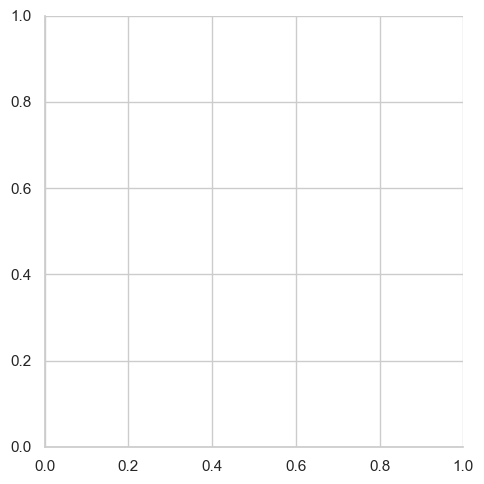

In [12]:
env = NormalizedActions(gym.make('Pendulum-v1'))
agent = DDPG(device, env.action_space.shape[0], env.observation_space.shape[0], batch_size, gamma, tau)
train_res = train(env,agent,train_eps,max_steps)
test_res = test(env,agent,test_eps,max_steps)



# 画出结果
draw(train_res,tag="train")
draw(test_res,tag="test")